In [286]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
# import pytesseract
from PIL import Image
from matplotlib import pyplot as plt
import re
import cv2
import numpy as np
from keras.models import load_model
# import pytesseract
import math
from PIL import Image
from matplotlib import pyplot as plt
import re
import cv2
import numpy as np

model = load_model('Models/model.h5')
def PredictImg(img):
    # 載入模型
    #縮放圖片大小
    Max_Width=20
    Max_Hight=20
    x_test = []
    # for img in imgs:
    try:
        img = cv2.resize(img, (Max_Width, Max_Hight), interpolation=cv2.INTER_CUBIC)
    except:
        return None
    x_test.append(img)
    x_test = np.array(x_test)
    x_test = x_test.reshape(x_test.shape[0], Max_Width, Max_Hight, 1)
    x_test = 255 - x_test
    x_test = x_test.astype('float32')
    x_test /= 255
    pred = model.predict(x_test,batch_size = 25)
    outdict = ['0','1','2','3','4','5','6','7','8','9']
    pred_result = outdict[np.argmax(pred)]
    return pred_result

#去除掉圖片的雜訊，使用filter來決定可不可以用
def ImageFilter(width,height):
    # 面積太小就算雜訊
    if width<=5 or width>20 or width*height<100 \
        or width*height>400 or height <= 14 or height > 20:
        return False 
    else:
        return True


#morphologyKernel = 形態學的設定Tuple format（第一次膨脹,第一次腐蝕,第二次腐蝕,第二次膨脹）
#erodeKernel = 膨脹的係數，可以設定對橫向敏感還是豎向
#adaptThreshold = 區塊大小
def imageProcess(img,threshValue,blur,morphologyKernel,erodeKernel,adaptThreshold):
    thresh1 = img.copy()

    #模糊化
    thresh1 = cv2.GaussianBlur(thresh1,blur,0) 
    plt.imshow(thresh1)
    plt.title('GaussianBlur')
    plt.show()  

    thresh1 = cv2.Sobel(thresh1, -1, 1, 0, ksize=3)
    plt.imshow(thresh1)
    plt.title('Sobel')
    plt.show()  

    #中值濾波   
    # thresh1 = cv2.medianBlur(thresh1, 5)
    # plt.imshow(thresh1)
    # plt.title('medianBlur')
    # plt.show()

    # thresh1 = cv2.adaptiveThreshold(thresh1,255,
    #                                 cv2.ADAPTIVE_THRESH_MEAN_C,                                                                cv2.THRESH_BINARY,
    #                                 adaptThreshold[0],
    #                                 adaptThreshold[1])
    #二值化
    ret,thresh1 = cv2.threshold(thresh1,threshValue,255,cv2.THRESH_BINARY_INV)


    # 因為後續的操作都會把文字抹去只留邊框，所以開一個能被模糊破壞的圖片資料
    # 保留還能顯示文字的版本
    erode_thresh = thresh1.copy()

    plt.imshow(thresh1)
    plt.title('thresh1')
    plt.show()  

 
    

    #閉運算（先膨脹再腐蝕，消除內部噪點）
    #只對橫向做膨脹
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT,erodeKernel)
    #膨脹
    erode_thresh = cv2.erode(erode_thresh, kernel, iterations = morphologyKernel[0])
    plt.imshow(erode_thresh)
    plt.title('erode_thresh')
    plt.show()  
    #腐蝕
    erode_thresh = cv2.dilate(erode_thresh, kernel, iterations = morphologyKernel[1])
    plt.imshow(erode_thresh)
    plt.title('erode_thresh')
    plt.show() 

   
    #開運算（先腐蝕再膨脹，清除外部小的躁點）
    #腐蝕
    erode_thresh = cv2.dilate(erode_thresh, kernel, iterations = morphologyKernel[2])
    plt.imshow(erode_thresh)
    plt.title('erode_thresh')
    plt.show() 

    #膨脹
    erode_thresh = cv2.erode(erode_thresh, kernel, iterations = morphologyKernel[3])
    plt.imshow(erode_thresh)
    plt.title('erode_thresh')
    plt.show()  

    

    originalImg = img.copy()
    
    #把完全看不到文字只剩下邊框的版本去做輪廓辨識
    image ,contours,hierarchy = cv2.findContours(erode_thresh,cv2.RETR_TREE,          cv2.CHAIN_APPROX_SIMPLE)
    DrawContours = originalImg.copy()
    sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

    
    for i in range(0,len(sorted_contours)):  
        x, y, width, height = cv2.boundingRect(sorted_contours[i]) 
        # print (x, y, width, height)
        # #面積太小就算雜訊
        # if ImageFilter(width, height) == False:
        #     continue
        cv2.rectangle(DrawContours, (x, y), (x + width, y + height), (153,153,0), 2) 

    plt.imshow(DrawContours)
    plt.title('DrawContours')
    plt.show()  
   
    #輸出
    return thresh1,contours



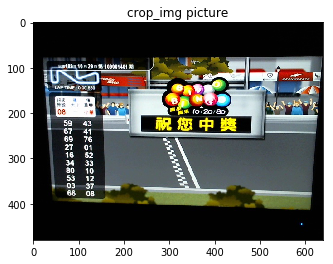

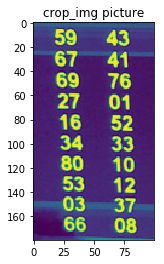

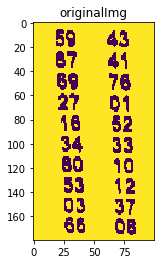

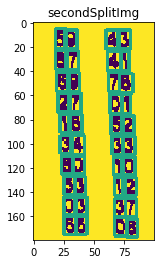

In [299]:

img = Image.open('7-1.jpg')
#二值化限制值
threshValue =230
plt.imshow(img)
plt.title('crop_img picture')
plt.show()


#x軸（橫向）
#y軸（直向）
#area = (x1,y1,
#        x2,y2)
area = (50, 210,
        150, 390)
crop_img = img.crop(area)


img = cv2.cvtColor(np.asarray(crop_img),cv2.COLOR_RGB2BGR)  
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

plt.imshow(img)
plt.title('crop_img picture')
plt.show()

thresh1 = img.copy()
_originalImg = img.copy() 
# 形態學的設定Tuple format（第一次膨脹,第一次腐蝕,第二次腐蝕,第二次膨脹）
# erodeKernel = (橫向,直向)
# thresh1,contours = imageProcess(_originalImg,127,blur = (7,7),
#                                morphologyKernel=(3,2,1,3),erodeKernel = (5,4),          
#                                adaptThreshold = (5,5))

originalImg = img.copy()                              
#二值化
ret,originalImg = cv2.threshold(originalImg,threshValue,255,        
                                cv2.THRESH_BINARY_INV)

#x軸（橫向）
#y軸（直向）
#膨脹
originalImg = cv2.erode(originalImg, (1,2), iterations = 2)
plt.imshow(originalImg)
plt.title('originalImg')
plt.show()


secondSplitImg = originalImg.copy()
#把完全看不到文字只剩下填滿黑色的色塊版本去做輪廓辨識
secondSplitImg ,Splitcontours,hierarchy = cv2.findContours(secondSplitImg,cv2.RETR_TREE,
                                                cv2.CHAIN_APPROX_SIMPLE)
offset = (0,0)
for i in range(0,len(Splitcontours)):  
    x, y, width, height = cv2.boundingRect(Splitcontours[i])  
    # 面積太小就算雜訊
    if ImageFilter(width, height) == False:
        continue
#     print (x, y, width, height)
    x = x + offset[0]
    y = y + offset[1]
    cv2.rectangle(secondSplitImg, (x, y),
                                (x + width, 
                                y + height), (153,153,0), 2) 
plt.imshow(secondSplitImg)
plt.title("secondSplitImg")
plt.show()

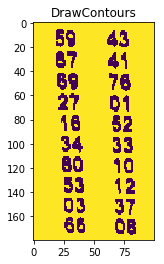

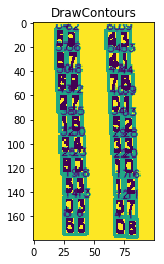

59,43,57,41,59,78,27,01,18,52,34,33,80,10,53,12,03,37,65,08,

In [300]:
#因為進行開閉運算後，邊緣會偏移，所以要有一個Offset 修正 (x,y,width,height)
#x軸（橫向）
#y軸（直向）
offset = (0,0,12,19)

sorted_contours = sorted(contours, key=lambda ctr: cv2.boundingRect(ctr)[0])

DrawContours = originalImg.copy()
plt.imshow(DrawContours)
plt.title("DrawContours")
plt.show()
for i in range(0,len(Splitcontours)):  
    x, y, width, height = cv2.boundingRect(Splitcontours[i]) 
    # 面積太小就算雜訊
    if ImageFilter(width, height) == False:
        continue
    x = x+offset[0]
    y = y+offset[1]
    #反正數字都是這個高度，那就固定起來
    # if height >=10:
    #     width = offset[2]
    #     height = offset[3]
    cv2.rectangle(DrawContours, (x, y),
                                (x + width, 
                                 y + height), (153,153,0), 2) 

for i in range(0,len(Splitcontours)):  
    x, y, width, height = cv2.boundingRect(Splitcontours[i])   
    # 面積太小就算雜訊
    if ImageFilter(width, height) == False:
        continue
    x = x+offset[0]
    y = y+offset[1]
    cv2.putText(DrawContours, str(i), (x,y), cv2.FONT_HERSHEY_SIMPLEX,
        0.3, (0, 255, 255), 1, cv2.LINE_AA)
#檢視成果
plt.imshow(DrawContours)

plt.title('DrawContours')
plt.show()

thresh1 = originalImg.copy()
#儲存所有號碼圖的位置圖
NumberImg = []
for i in range(0,len(Splitcontours)):  
    x, y, width, height = cv2.boundingRect(Splitcontours[i])   
    # 面積太小就算雜訊
    if ImageFilter(width, height) == False:
        continue
    # print (i,",",x, y, width, height)
    #x軸（橫向）
    #y軸（直向）
    x = x+offset[0]
    y = y+offset[1]

    newImage=originalImg[y:y+height,
                     x:x+width]

    
    NumberImg.append(newImage)
    input_dir=("cut_image/")
    if not os.path.isdir(input_dir):
        os.makedirs(input_dir)
    cv2.imwrite("./cut_image/" + str(i)+".jpg",newImage) 
    # cv2.imwrite("./cut_image/" + str(i)+"_.jpg",newImage2) 



output = []
for img in NumberImg:
    predValue = PredictImg(img)
    # plt.imshow(img)
    # plt.title(predValue)
    # plt.show()
    output.append(predValue)

output.reverse()

#每兩個數字為一組，這樣比較好區分數組
step = 2
output = [output[i:i+step] for i in range(0,len(output),step)]
for ele in output:
    try:
        print (''.join(ele) + "," , end='')
    except:
        continue

